In [14]:
# setup
import sys
import subprocess
import re
import os
import spacy
import numpy as np
import pandas as pd
import transformers

from bs4 import BeautifulSoup
from spacy.lang.en import English

nlp = spacy.load('en_core_web_md')

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))


import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


#Importuojame paketus
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HUAWEI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HUAWEI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
def simple_tokenizer(doc):
    parsed = nlp(doc)
    # suskaidom tekstą į atskirus žodžius
    # žodžius transformuojam į mažasias raides, ir pridedam tokeną jei jis abėcėlės simbolis, bet nera url ir stop simbolis
    return([t.lower_ for t in parsed if (t.is_alpha)&(not t.like_url)&(not t.is_stop)])

## Importuojame duomenis

In [120]:
# Fake and real news Kaggle dataset
kaggle_data = pd.read_csv('data/kaggle/combined.csv', sep=";")

# Get rid of unnecessary data
kaggle_data.drop(columns=['subject'], inplace=True)

kaggle_data.head()

,label,title,text
0,1,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...
1,1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...
2,1,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk..."
3,1,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ..."
4,1,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...


In [121]:
# WELFake dataset (will need to select a subset, since it's huge)
wellfake_data = pd.read_csv('data/welfake/data.csv', sep=';', encoding_errors='ignore')

wellfake_data.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMAS ATTORNEY GENERAL SAYS MOS...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [122]:
# Proppy dataset (will need to drop real news to to balance dataset (undersample?))
proppy_dev = pd.read_csv('data/proppy/data-dev.csv',  sep=';', encoding_errors='ignore')
proppy_test = pd.read_csv('data/proppy/data-test.csv',  sep=';', encoding_errors='ignore')
proppy_train = pd.read_csv('data/proppy/data-train.csv',  sep=';', encoding_errors='ignore')

proppy_data = pd.concat([proppy_dev, proppy_test, proppy_train], ignore_index=True, sort=False)

# Get rid of unnecessary data
proppy_data.drop(columns=['source'], inplace=True)

# Change label from -1 to 0, to match others 
proppy_data['label'].mask(proppy_data['label'] == -1.0, 0, inplace=True)

# Rename columns 
proppy_data.rename(columns={"article_text": "text", "headline": "title"}, inplace=True)

proppy_data.head()

,text,title,label
0,Convened to examine the causes of civil unrest...,Report: No progress for African-Americans on h...,0.0
1,Discriminating against someone on the basis of...,Employers can't discriminate based on sexual o...,0.0
2,"Bill Cosby's 44-year-old daughter, Ensa Cosby,...","Bill Cosby's daughter Ensa, 44, dies in Massac...",0.0
3,"The fast-moving, powerful theatrical locomotiv...","'Murder On The Orient Express' A Funny, Fast-P...",0.0
4,It's Friday. It's National Pizza Day. Grab lif...,You Can Celebrate National Pizza Day Right Here,0.0


#### Clean data

In [127]:
# Remove duplicates
print("Kaggle data dupe num", kaggle_data.duplicated().sum())
kaggle_data.drop_duplicates(inplace = True)

print("WellFake data dupe num", wellfake_data.duplicated().sum())
wellfake_data.drop_duplicates(inplace = True)

print("Proppy data dupe num", proppy_data.duplicated().sum())
proppy_data.drop_duplicates(inplace = True)

# Drop invalid rows (containing NaN/Empty values)
print("\nKaggle null values\n", kaggle_data.isnull().sum())
kaggle_data.dropna(inplace = True)

print("Wellfake null values\n", wellfake_data.isnull().sum())
wellfake_data.dropna(inplace=True)

print("Proppy null value rows\n", proppy_data.isnull().sum())
proppy_data.dropna(inplace=True)


Kaggle data dupe num 0
WellFake data dupe num 0
Proppy data dupe num 0

Kaggle null values
 label    0
title    0
text     0
dtype: int64
Wellfake null values
 title    0
text     0
label    0
dtype: int64
Proppy null value rows
 text     0
title    0
label    0
dtype: int64


#### Undersampling Proppy Data (should be done prior to training, but after vectorizing)

In [102]:
# print(len(proppy_data))
# # Tik ~ 10% visu duomenu, tad atliksime undersampling undersampling 
# count_pos = len(proppy_data.loc[proppy_data['label'] == 1])
# count_neg = len(proppy_data.loc[proppy_data['label'] == 0])
# print(count_neg)
# print(count_pos)

# # Undersample and plot imbalanced dataset 
# from collections import Counter
# from sklearn.datasets import make_classification
# from imblearn.under_sampling import TomekLinks
# from imblearn.under_sampling import CondensedNearestNeighbour  

# # define dataset
# X, y = proppy_data['text'], proppy_data['label']

# # summarize class distribution
# counter = Counter(y)
# print(counter)

# # define the undersampling method
# undersample = CondensedNearestNeighbour(n_neighbors=1)
# # transform the dataset
# X, y = undersample.fit_resample(X, y)
# # summarize the new class distribution
# counter = Counter(y)
# print(counter)
# # scatter plot of examples by class label
# for label, _ in counter.items():
#   row_ix = np.where(y == label)[0]
#   plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
# plt.legend()
# plt.show()



#### Duomenų rinkinių analizė 

##### Klasių pasiskirstymas (WellFake)

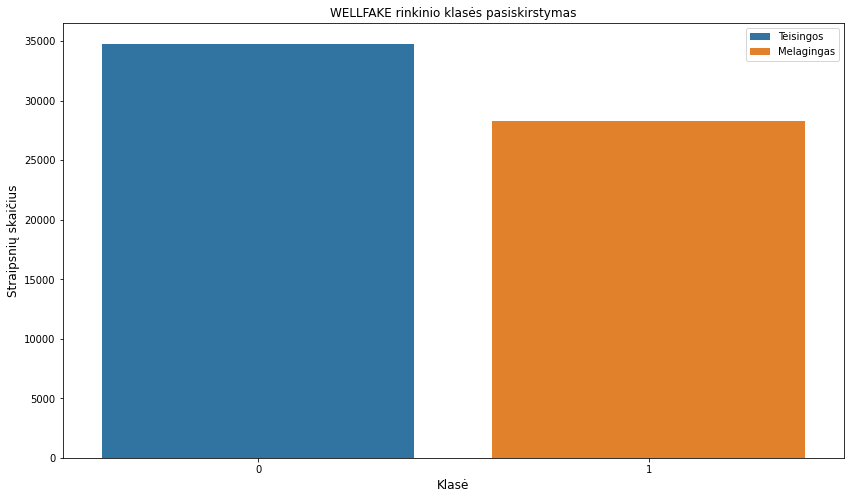

In [129]:
plt.figure(figsize=(14,8))
sns.countplot(x='label', hue="label",dodge=False, data=wellfake_data)
plt.title('WELLFAKE rinkinio klasės pasiskirstymas')
plt.ylabel('Straipsnių skaičius', fontsize=12)
plt.xlabel('Klasė', fontsize=12)
plt.legend(['Teisingos', 'Melagingas'], loc="upper right")

plt.show()


##### Klasių pasiskirstymas (Kaggle)

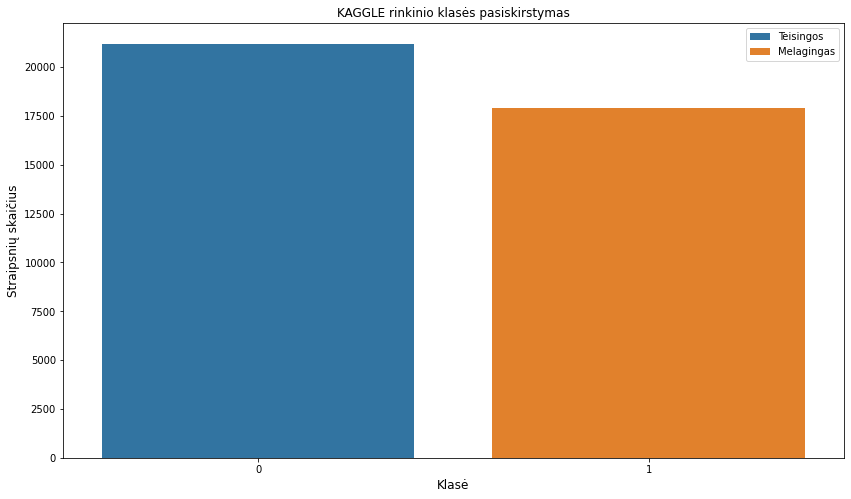

In [128]:
plt.figure(figsize=(14,8))
sns.countplot(x='label', hue="label",dodge=False, data=kaggle_data)
plt.title('KAGGLE rinkinio klasės pasiskirstymas')
plt.ylabel('Straipsnių skaičius', fontsize=12)
plt.xlabel('Klasė', fontsize=12)
plt.legend(['Teisingos', 'Melagingas'], loc="upper right")

plt.show()

##### Klasių pasiskirstymas (Proppy)

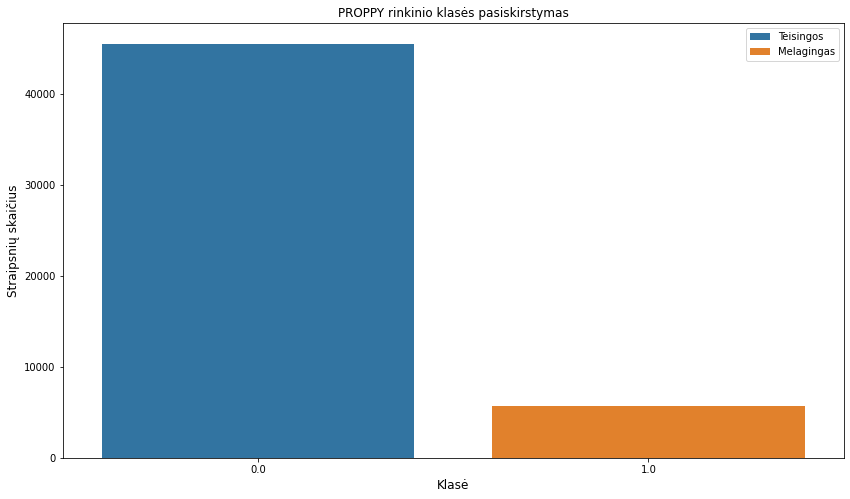

In [130]:
plt.figure(figsize=(14,8))
sns.countplot(x='label', hue="label",dodge=False, data=proppy_data)
plt.title('PROPPY rinkinio klasės pasiskirstymas')
plt.ylabel('Straipsnių skaičius', fontsize=12)
plt.xlabel('Klasė', fontsize=12)
plt.legend(['Teisingos', 'Melagingas'], loc="upper right")

plt.show()

### Pravalome teksta

In [131]:
# Aprasyti sita dali darbe (prie pradinio teksto apdorojimo)

def expand_shorthand(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.replace('\n', ' ')
    text = text.strip(' ')
    return text

# removal of HTML Contents
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# remove urls
def remove_url(text):
    return re.sub(r'http\S+', '', text)

# removal of Punctuation Marks
def remove_punctuation(text):
    return re.sub('\[[^]]*\]', '', text)

# Removal of Special Characters
def remove_special_characters(text):
    return re.sub('[^a-zA-Z]', ' ', text)

# Removal of stopwords 
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word) 
            final_text.append(word)
    return " ".join(final_text)

# Unifying function
def clean_text(text):
    # text = expand_shorthand(text)
    text = remove_html(text)
    # text = remove_url(text)
    text = remove_punctuation(text)
    text = remove_special_characters(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

In [139]:
# KAGGLE
# cleaning primary text
print(kaggle_data['text'][0])
print("\n")
print(clean_text(kaggle_data['text'][0]))
# cleaning title
print("\n")
print(kaggle_data['title'][0])
print(clean_text(kaggle_data['title'][0]))

Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t eve

In [140]:
# WELLFAKE
# cleaning primary text
print(wellfake_data['text'][0])
print("\n")
print(clean_text(wellfake_data['text'][0]))
# cleaning title
print("\n")
print(wellfake_data['title'][0])
print(clean_text(wellfake_data['title'][0]))

No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called  Sunshine.  She has a radio blog show hosted from Texas called,  Sunshine s F***ing Opinion Radio Show. A snapshot of her #FYF911 @LOLatWhiteFear Twitter page at 9:53 p.m. shows that she was urging supporters to  Call now!! #fyf911 tonight we continue to dismantle the illusion of white Below is a SNAPSHOT Twitter Radio Call Invite   #FYF911The radio show aired at 10:00 p.m. eastern standard time.During the show, callers clearly call for  lynching  and  killing  of white people.A 2:39 minute clip from the radio show can be heard here. It was provided to Breitbart Texas by someone who would like to be referred to 

In [141]:
# PROPPY
# cleaning primary text
print(proppy_data['text'][0])
print("\n")
print(clean_text(proppy_data['text'][0]))
# cleaning title
print("\n")
print(proppy_data['title'][0])
print(clean_text(proppy_data['title'][0]))

Convened to examine the causes of civil unrest in black communities, the presidential commission issued a 1968 report with a stark conclusion: America was moving towards two societies, "one black, one white — separate and unequal."  Fifty years after the historic Kerner Commission identified "white racism" as the key cause of "pervasive discrimination in employment, education and housing," there has been no progress in how African-Americans fare in comparison to whites when it comes to homeownership, unemployment and incarceration, according to a report by the Economic Policy Institute released Monday.  In some cases, African-Americans are worse off today than they were before the civil rights movement culminated in laws barring housing and voter discrimination as well as racial segregation.  7.5 percent of African-Americans were unemployed in 2017, compared to 6.7 percent in 1968 — still roughly twice the white unemployment rate.  The rate of homeownership, one of the most important w

In [144]:
kaggle_data['text']=kaggle_data['text'].apply(clean_text)
kaggle_data['title']=kaggle_data['title'].apply(clean_text)

In [ ]:
wellfake_data['text']=wellfake_data['text'].apply(clean_text)
wellfake_data['title']=wellfake_data['title'].apply(clean_text)

In [ ]:
proppy_data['text']=proppy_data['text'].apply(clean_text)
proppy_data['title']=proppy_data['title'].apply(clean_text)

### Dazniausiai naudojami zodziai pagal klasę

#### Kaggle

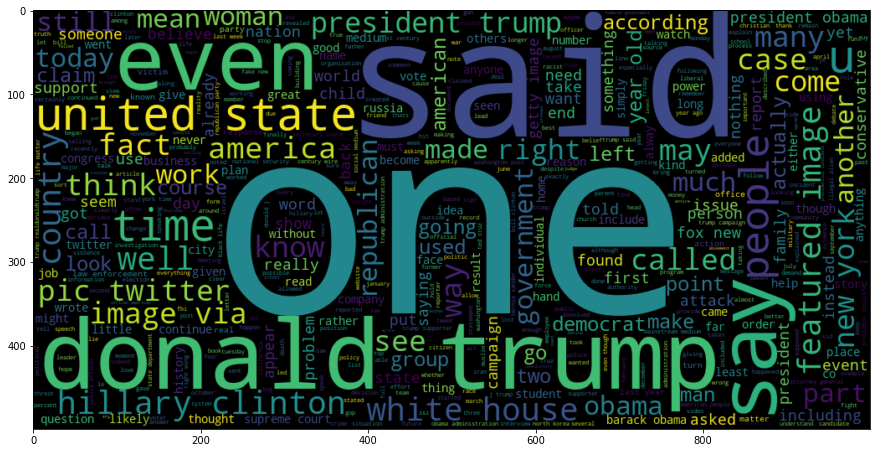

In [ ]:
# Fake news (turinys)
df_pos = kaggle_data.loc[kaggle_data['label'] == 1.0]

plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(df_pos.text))
plt.imshow(wc , interpolation = 'bilinear') 

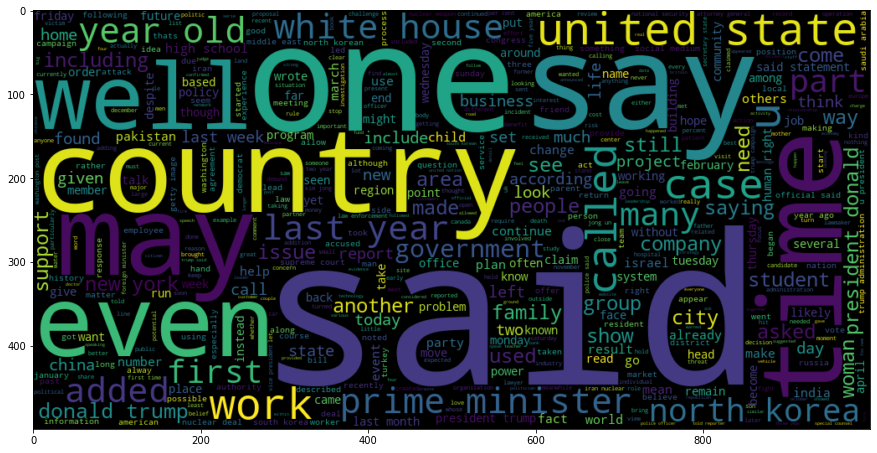

In [ ]:
# Real news (turinys)
df_neg = kaggle_data.loc[kaggle_data['label']==0.0]

plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(df_neg.text))
plt.imshow(wc , interpolation = 'bilinear') 

In [ ]:
# Fake news (antraste)
df_pos = kaggle_data.loc[kaggle_data['title'] == 1.0]

plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(df_pos.title))
plt.imshow(wc , interpolation = 'bilinear') 

In [ ]:
# Real news (antraste)
df_pos = kaggle_data.loc[kaggle_data['title'] == 0.0]

plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(df_pos.title))
plt.imshow(wc , interpolation = 'bilinear') 

## Vidutinis žodžių skaičius kiekviename tipe

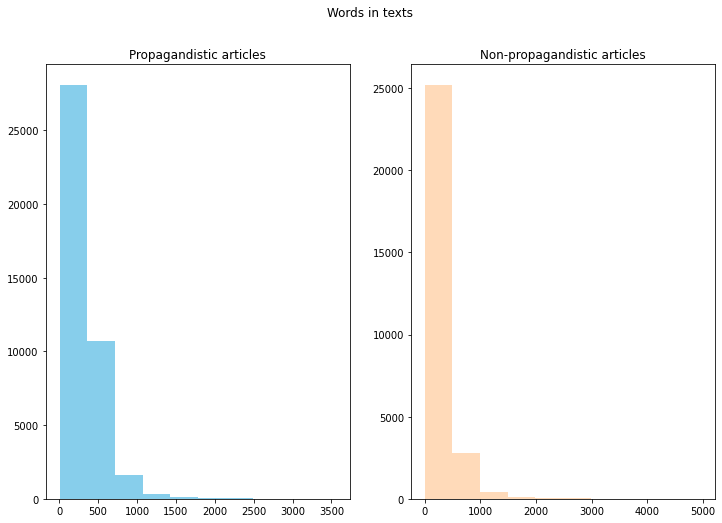

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['label']==0]['article_text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='SkyBlue')
ax1.set_title('Propagandistic articles')
text_len=df[df['label']==1]['article_text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='PeachPuff')
ax2.set_title('Non-propagandistic articles')
fig.suptitle('Words in texts')
plt.show()

## Padalijame duomenų rinkinį į mokymo ir testavimo rinkinius

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split(kaggle_data['text'], kaggle_data['label'], random_state=0)
X_title_train, X_title_test, y_title_train, y_title_test = train_test_split(kaggle_data['title'], kaggle_data['label'], random_state=0)


print(X_train.shape)
print(X_test.shape)

print(X_title_train.shape)
print(X_title_test.shape)


(29328,)
(9777,)


## Klasifikatoriaus mokymas

In [ ]:
#Importuojame paketus
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import keras
from keras.preprocessing import text,sequence
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout

labels = kaggle_data['label'].unique()

### Tokenizavimas

In [ ]:
max_features = 10000
maxlen = 300

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(tokenized_train, maxlen=maxlen)
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

### LTSM 

In [ ]:
batch_size = 256
epochs = 10
embed_size = 100

# Aprašyti kaip veikia modelis 

model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

c:\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

c:\Python39\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/10
143/143 [==============================] - 2658s 19s/step - loss: 0.4728 - accuracy: 0.7773 - val_loss: nan - val_accuracy: 0.8233
Epoch 2/10
143/143 [==============================] - 2936s 21s/step - loss: 0.3926 - accuracy: 0.8269 - val_loss: nan - val_accuracy: 0.8425
Epoch 3/10
143/143 [==============================] - 76879s 541s/step - loss: 0.3387 - accuracy: 0.8517 - val_loss: nan - val_accuracy: 0.8701
Epoch 4/10
143/143 [==============================] - 3158s 22s/step - loss: 0.2800 - accuracy: 0.8827 - val_loss: nan - val_accuracy: 0.8964
Epoch 5/10
143/143 [==============================] - 3148s 22s/step - loss: 0.2431 - accuracy: 0.9002 - val_loss: nan - val_accuracy: 0.8980
Epoch 6/10
143/143 [==============================] - 72335s 509s/step - loss: 0.2260 - accuracy: 0.9089 - val_loss: nan - val_accuracy: 0.9132
Epoch 7/10
143/143 [==============================] - 3217s 23s/step - loss: 0.2055 - accuracy: 0.9163 - val_loss: nan - val_accuracy: 0.9191
Ep

In [ ]:
#### Klasifikatoriaus mokymas su antrastemis
history_title = model.fit(X_title_train, y_title_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

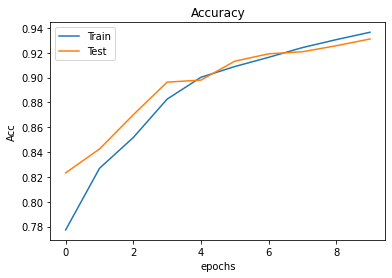

In [ ]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

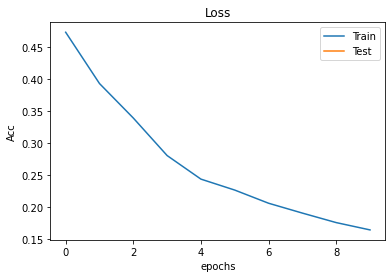

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()